In [1]:
import pandas as pd
import json

tweets_data = []

# Load tweets_DM.json
with open('/kaggle/input/dm2023/tweets_DM.json', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweets_data.append({'tweet_id': tweet['_source']['tweet']['tweet_id'], 'text': tweet['_source']['tweet']['text']})
tweets_df = pd.json_normalize(tweets_data)

# Load emotion.csv
emotion_df = pd.read_csv('/kaggle/input/dm2023/emotion.csv')

# rename emotion to label
emotion_df.rename(columns={'emotion':'label'}, inplace=True)

# Load data_identification.csv
data_identification_df = pd.read_csv('/kaggle/input/dm2023/data_identification.csv')

# Merge the dataframes
merged_df = pd.merge(tweets_df, emotion_df, on='tweet_id')
merged_df = pd.merge(merged_df, data_identification_df, on='tweet_id')

# make train_df and test_df based on data_identification_df
train_df = merged_df[merged_df['identification'] == 'train']
test_df = merged_df[merged_df['identification'] == 'test']

# drop data from train_df where label is None
train_df = train_df[train_df['label'] != 'empty']
print(train_df['label'].isnull().sum())

# only use first 3000 tweets for training
train_df = train_df[:800000]

test_df = pd.merge(tweets_df, data_identification_df, on='tweet_id')
test_df = test_df[test_df['identification'] == 'test']

0


In [3]:
# rename _source.tweet.text to text
#train_df.rename(columns={'_source.tweet.text':'text'}, inplace=True)
#test_df.rename(columns={'_source.tweet.text':'text'}, inplace=True)
train_df.head()
# drop everything except tweet_id, text, and emotion
train_df = train_df[['text', 'label']]

In [4]:
len(train_df)

800000

### **Class Distribution**

With Pandas and Matplotlib, we can quickly visualize the class distribution as follows:

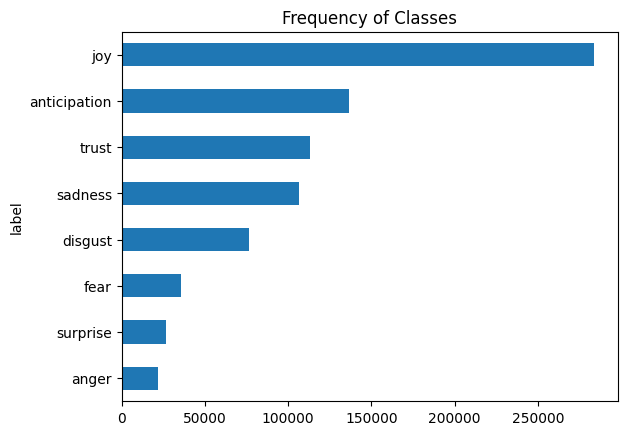

In [5]:
import matplotlib.pyplot as plt

train_df["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

### **How Long Are Our Tweets?**

### **From Text to Tokens**

In [7]:
# hide_output
from transformers import AutoTokenizer

#model_ckpt = "distilbert-base-uncased"
model_ckpt = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [8]:
def tokenize(batch):
    return tokenizer(batch['text'].astype(str).tolist(), padding=True, truncation=True)

In [9]:
print(tokenize(train_df[:2]))

{'input_ids': [[0, 4763, 54, 618, 22, 4917, 162, 15, 849, 41513, 29465, 113, 531, 28, 36410, 8358, 4, 230, 4987, 313, 17220, 14, 18, 28696, 574, 725, 15698, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1039, 428, 1069, 3153, 2560, 281, 287, 52, 192, 6, 140, 16, 2702, 7, 849, 18178, 2462, 5224, 198, 5, 232, 4, 653, 10, 28696, 574, 725, 15698, 28696, 574, 725, 15698, 849, 7565, 32102, 5073, 4, 1437, 849, 16256, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [10]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,<s>,<pad>,</s>,<unk>,<mask>
Special Token ID,0,1,2,3,50264


In [11]:
# # hide_output
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


label2id = {
    "sadness": 0,
    "joy": 1,
    "disgust": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5,
    "trust": 6,
    "anticipation": 7
}

# convert emotion to id
train_df['label'] = train_df['label'].map(label2id)

# Get the count of the least common class
min_class_count = train_df['label'].value_counts().min()
print(train_df['label'].value_counts())

# split into train and validation
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# convert to dataset
train_dataset = Dataset.from_pandas(train_df)

del train_df
val_dataset = Dataset.from_pandas(val_df)
del val_df

# Then apply the tokenize function to the 'text' column
def encode(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

train_dataset = train_dataset.map(encode, batched=True, batch_size=None)
val_dataset = val_dataset.map(encode, batched=True, batch_size=None)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


label
1    283639
7    136804
6    112944
0    106361
2     76599
4     35384
5     26486
3     21783
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

# Fine-Tuning Transformers

In [12]:
from transformers import AutoModelForSequenceClassification
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# hide_output
num_labels = 8
id2label = {
    "0": "sadness",
    "1": "joy",
    "2": "disgust",
    "3": "anger",
    "4": "fear",
    "5": "surprise",
    "6": "trust",
    "7": "anticipation"
}

label2id = {
    "sadness": 0,
    "joy": 1,
    "disgust": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5,
    "trust": 6,
    "anticipation": 7
}

model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)
         .to(device))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [14]:
from huggingface_hub import notebook_login

notebook_login()

In [15]:
from transformers import Trainer, TrainingArguments
import os
os.environ["WANDB_DISABLED"] = "true"

batch_size = 32
logging_steps = 800000 // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(report_to=None,
                                  output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error",
                                  save_strategy = "epoch",
                                  save_total_limit = 2,
                                  load_best_model_at_end = True)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [16]:
from transformers import Trainer

# count rows where label is None in train_df
#print(train_df['label'].isnull().sum())
#print(len(train_df))

#train_dataset = train_dataset.map(lambda examples: tokenizer(examples['text'], truncation=True, padding='longest'), batched=True)
#val_dataset = val_dataset.map(lambda examples: tokenizer(examples['text'], truncation=True, padding='longest'), batched=True)


trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.998781,0.640038,0.627409
2,1.074800,0.966344,0.652900,0.644313


TrainOutput(global_step=40000, training_loss=1.02379326171875, metrics={'train_runtime': 22845.7807, 'train_samples_per_second': 56.028, 'train_steps_per_second': 1.751, 'total_flos': 1.0697887008768e+17, 'train_loss': 1.02379326171875, 'epoch': 2.0})

In [17]:
# hide_output
preds_output = trainer.predict(val_dataset)

In [18]:
preds_output.metrics

{'test_loss': 0.96634441614151,
 'test_accuracy': 0.6529,
 'test_f1': 0.6443129089481171,
 'test_runtime': 790.6953,
 'test_samples_per_second': 202.354,
 'test_steps_per_second': 6.324}

In [19]:
import numpy as np

# Convert the test_df to a dataset
#test_df['text'] = test_df['text'].str.replace(r'[^#@0-9a-zA-Z ]', '')
test_dataset = Dataset.from_pandas(test_df)

#del test_df

# Then apply the tokenize function to the 'text' column
test_dataset = test_dataset.map(encode, batched=True, batch_size=None)

# Make predictions on the test dataset
test_predictions = trainer.predict(test_dataset)





/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


  0%|          | 0/1 [00:00<?, ?ba/s]

In [20]:
test_labels = np.argmax(test_predictions.predictions, axis=1)


test_emotions = [id2label[str(label_id)] for label_id in test_labels]

# Create a DataFrame with 'id' and 'emotion' columns
submission = pd.DataFrame({
    'id': test_df['tweet_id'],
    'emotion': test_emotions
})

# Save the DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)